In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

**Importacion de datos procesados**

Importamos los datos procesados en el analisis EDA

In [3]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


**Creación de funciones generales**

Crearemos funciones generales que seran usadas en cada variante que haremos con las variables predictoras, esto con el fin de evitar escribir codigo en cada variante

In [4]:
def crear_modelo_regresion(df):

    variable_dependiente = 'pib'
    X = df.drop(columns=[variable_dependiente])
    y = df[variable_dependiente]
    
    print(f"Tamaño del conjunto de entrenamiento: {X.shape[0]} (100% de los datos)")
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    
    # Realizar predicciones sobre los mismos datos de entrenamiento
    y_pred = modelo.predict(X)
    
    return modelo, X, y, y_pred

In [5]:
def evaluar_modelo(modelo, X, y, y_pred):

    print("="*60)
    print("EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE")
    print("="*60)
    
    # Coeficientes del modelo
    variables = X.columns
    print("\n1. COEFICIENTES DEL MODELO:")
    print(f"Intercepto: {modelo.intercept_:.4f}")
    for i, var in enumerate(variables):
        print(f"{var}: {modelo.coef_[i]:.4f}")
    
    # Métricas del modelo
    print("\n2. MÉTRICAS DEL MODELO:")
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # R² ajustado
    n = len(y)
    p = len(variables)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"\n3. R² AJUSTADO: {r2_adj:.4f}")
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'r2_adjusted': r2_adj
    }

In [6]:
def graficar_resultados(y, y_pred):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico 1: Valores reales vs predicciones
    axes[0].scatter(y, y_pred, alpha=0.7, color='blue')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valores Reales')
    axes[0].set_ylabel('Predicciones')
    axes[0].set_title('Valores Reales vs Predicciones')
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Residuos
    residuos = y - y_pred
    axes[1].scatter(y_pred, residuos, alpha=0.7, color='blue')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Predicciones')
    axes[1].set_ylabel('Residuos')
    axes[1].set_title('Análisis de Residuos')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [7]:
def analisis_residuos(y, y_pred):

    residuos = y - y_pred
    
    print("\n4. ANÁLISIS DE RESIDUOS:")
    
    # Test de normalidad de residuos (Shapiro-Wilk)
    if len(residuos) <= 5000:  # Shapiro-Wilk tiene límite de muestra
        stat, p_value = stats.shapiro(residuos)
        print(f"Test de Normalidad (Shapiro-Wilk): p-valor = {p_value:.4f}")
        if p_value > 0.05:
            print("Los residuos siguen una distribución normal (p > 0.05)")
        else:
            print("Los residuos NO siguen una distribución normal (p ≤ 0.05)")
    
    # Estadísticas básicas de residuos
    print(f"Media de residuos: {np.mean(residuos):.6f}")
    print(f"Desviación estándar de residuos: {np.std(residuos):.4f}")
    
    # Durbin-Watson (aproximado para autocorrelación)
    dw = np.sum(np.diff(residuos)**2) / np.sum(residuos**2)
    print(f"Estadístico Durbin-Watson: {dw:.4f}")
    if 1.5 < dw < 2.5:
        print("No hay evidencia fuerte de autocorrelación")
    else:
        print("Posible autocorrelación en los residuos")

In [8]:
def diagnosticos_modelo(X,y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print("AIC:", model.aic)
    print("BIC:", model.bic)
    print("R2 ajustado:", model.rsquared_adj)

In [9]:
def hacer_prediccion(modelo, nuevos_datos):
    prediccion = modelo.predict(nuevos_datos)
    return prediccion

In [10]:
def crear_y_evaluar_modelo_completo(df):
    modelo, X, y, y_pred = crear_modelo_regresion(df)
    metricas = evaluar_modelo(modelo, X, y, y_pred)
    analisis_residuos(y, y_pred)
    print("\n=== DIAGNÓSTICOS DEL MODELO ===")
    diagnosticos_modelo(X, y)
    graficar_resultados(y, y_pred)
    
    return modelo, metricas

**Generación de modelos**

En esta sección generaremos los modelos, cada uno variando en sus variables predictoras para ver el comportamiento y poder elegir el mejor modelo

**Modelo: M1**

En este modelo usaremos como variables predictoras: 
- exportaciones
- importaciones 
- precio del petroleo 
- consumo final 
- inversion total 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 65 (100% de los datos)
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0000
exportaciones: 0.1727
importaciones: 0.1273
precio_petroleo: 0.0302
consumo_final: 0.6430
inversion_total: 0.1302
tasa_inflacion: 0.1907

2. MÉTRICAS DEL MODELO:
R² Score: 0.9107
RMSE: 0.2988
MAE: 0.2369

3. R² AJUSTADO: 0.9015

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.1950
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: -0.000000
Desviación estándar de residuos: 0.2988
Estadístico Durbin-Watson: 2.1190
No hay evidencia fuerte de autocorrelación

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 41.43762313459267
BIC: 56.658334023862125
R2 ajustado: 0.9014626598283112


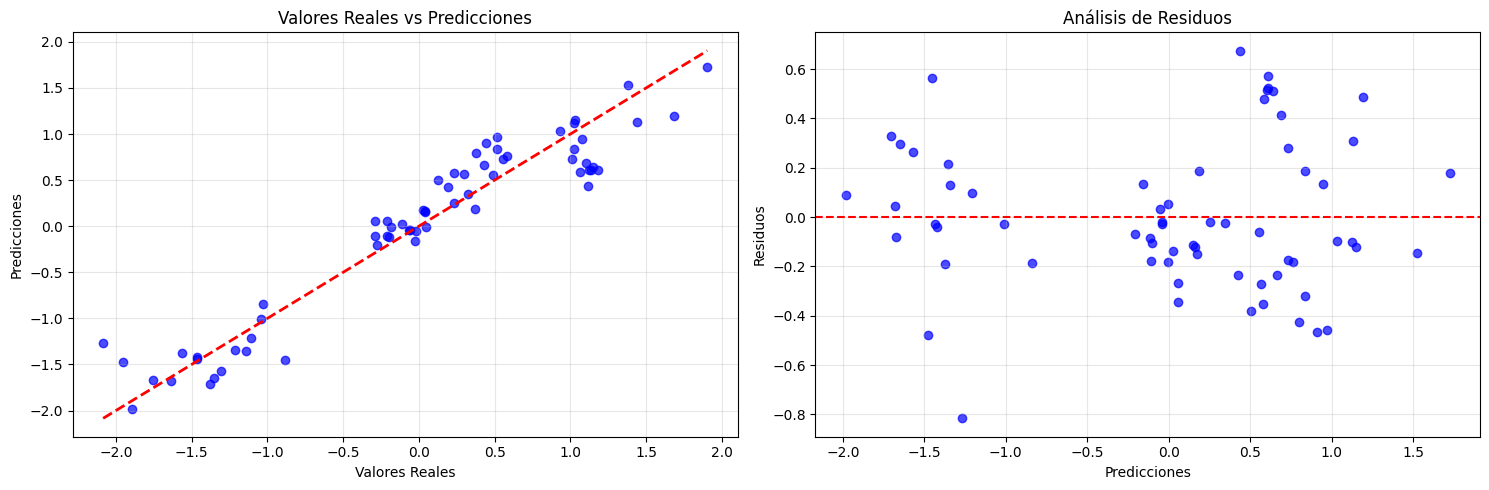

(LinearRegression(),
 {'r2': 0.910700535469407,
  'rmse': 0.2988301600083115,
  'mae': 0.23689662316795346,
  'r2_adjusted': 0.9014626598283112})

In [11]:
df1 = df.drop('igae', axis=1)
crear_y_evaluar_modelo_completo(df1)

**Modelo: M2**

En este modelo usaremos como variables predictoras: 
- exportaciones
- precio del petroleo 
- inversion total 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 65 (100% de los datos)
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0000
exportaciones: 0.1477
precio_petroleo: 0.0497
inversion_total: 0.8156
tasa_inflacion: 0.0114

2. MÉTRICAS DEL MODELO:
R² Score: 0.7856
RMSE: 0.4631
MAE: 0.3031

3. R² AJUSTADO: 0.7713

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.0001
Los residuos NO siguen una distribución normal (p ≤ 0.05)
Media de residuos: -0.000000
Desviación estándar de residuos: 0.4631
Estadístico Durbin-Watson: 2.0375
No hay evidencia fuerte de autocorrelación

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 94.37559912824847
BIC: 105.24753547772664
R2 ajustado: 0.7712790105252006


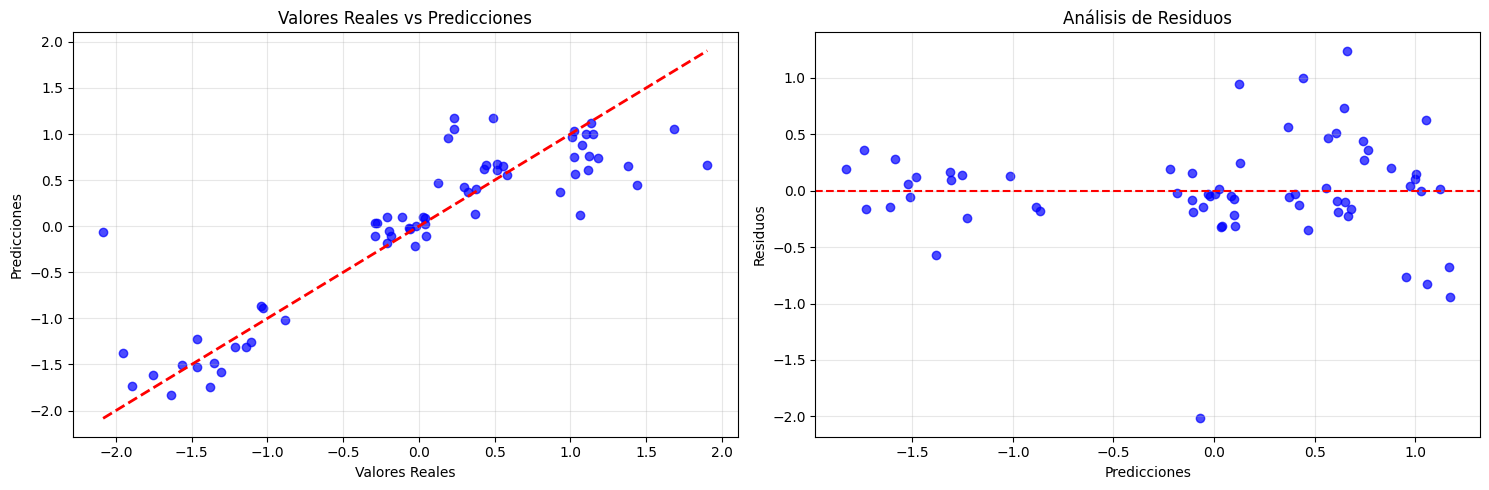

(LinearRegression(),
 {'r2': 0.7855740723673756,
  'rmse': 0.46306147284418336,
  'mae': 0.3030887490069371,
  'r2_adjusted': 0.7712790105252006})

In [12]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
crear_y_evaluar_modelo_completo(df2)

**Modelo: M3**

En este modelo usaremos como variables predictoras: 
- importaciones 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 65 (100% de los datos)
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0000
importaciones: 0.2736
precio_petroleo: 0.0675
consumo_final: 0.6970
tasa_inflacion: 0.2397

2. MÉTRICAS DEL MODELO:
R² Score: 0.8922
RMSE: 0.3284
MAE: 0.2563

3. R² AJUSTADO: 0.8850

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.5741
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: 0.000000
Desviación estándar de residuos: 0.3284
Estadístico Durbin-Watson: 2.3582
No hay evidencia fuerte de autocorrelación

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 49.68825911427642
BIC: 60.5601954637546
R2 ajustado: 0.8849915808747345


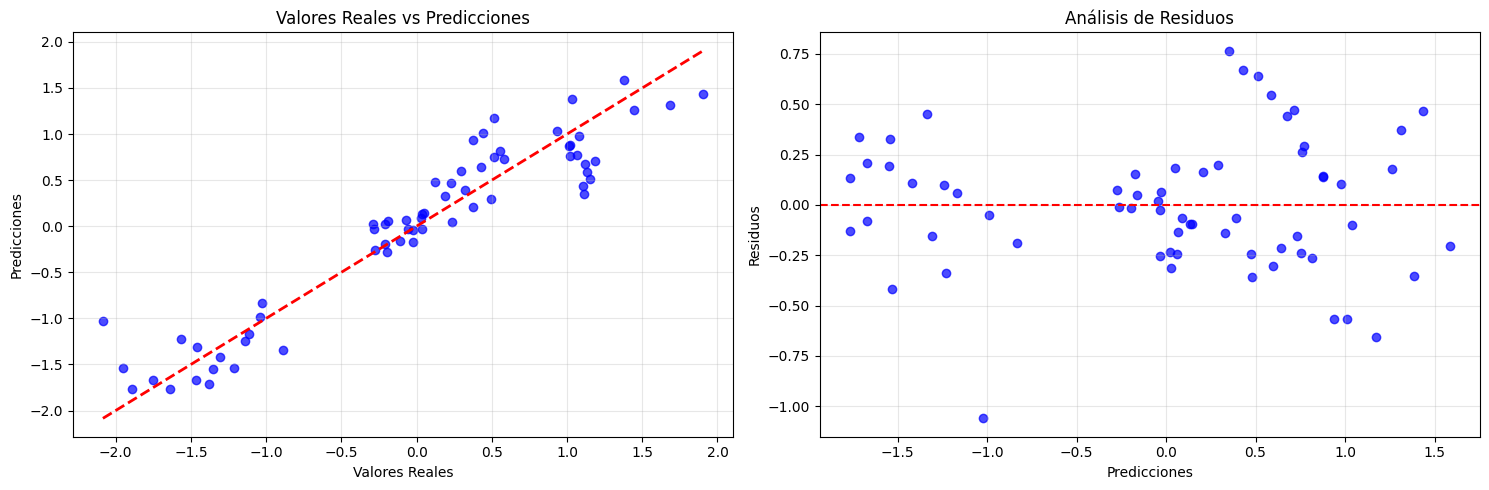

(LinearRegression(),
 {'r2': 0.8921796070700636,
  'rmse': 0.3283601573424163,
  'mae': 0.2563298934006281,
  'r2_adjusted': 0.8849915808747345})

In [13]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df3)

**Modelo: M4**

En este modelo usaremos como variables predictoras: 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 65 (100% de los datos)
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0000
precio_petroleo: 0.1259
consumo_final: 0.8142
tasa_inflacion: 0.2942

2. MÉTRICAS DEL MODELO:
R² Score: 0.8396
RMSE: 0.4005
MAE: 0.3151

3. R² AJUSTADO: 0.8317

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.9192
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: 0.000000
Desviación estándar de residuos: 0.4005
Estadístico Durbin-Watson: 2.4041
No hay evidencia fuerte de autocorrelación

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 73.51721267414477
BIC: 82.21476175372732
R2 ajustado: 0.8316837669134007


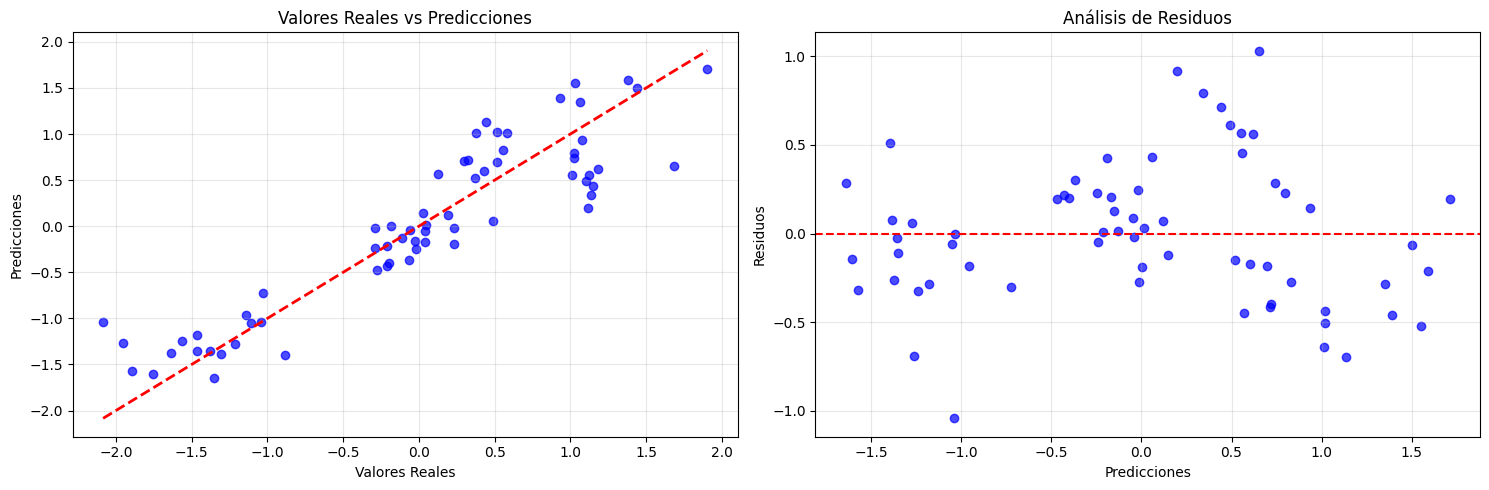

(LinearRegression(),
 {'r2': 0.8395735903393351,
  'rmse': 0.40053265742092103,
  'mae': 0.3151189888604739,
  'r2_adjusted': 0.8316837669134007})

In [14]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df4)

**Modelo: M5**

En este modelo usaremos como variables predictoras: 
- importaciones 
- precio del petroleo 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 65 (100% de los datos)
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0000
importaciones: 0.6022
precio_petroleo: -0.0480
tasa_inflacion: 0.2681

2. MÉTRICAS DEL MODELO:
R² Score: 0.5164
RMSE: 0.6954
MAE: 0.4980

3. R² AJUSTADO: 0.4926

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.0251
Los residuos NO siguen una distribución normal (p ≤ 0.05)
Media de residuos: 0.000000
Desviación estándar de residuos: 0.6954
Estadístico Durbin-Watson: 2.5789
Posible autocorrelación en los residuos

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 145.23732696409994
BIC: 153.9348760436825
R2 ajustado: 0.49263486918215504


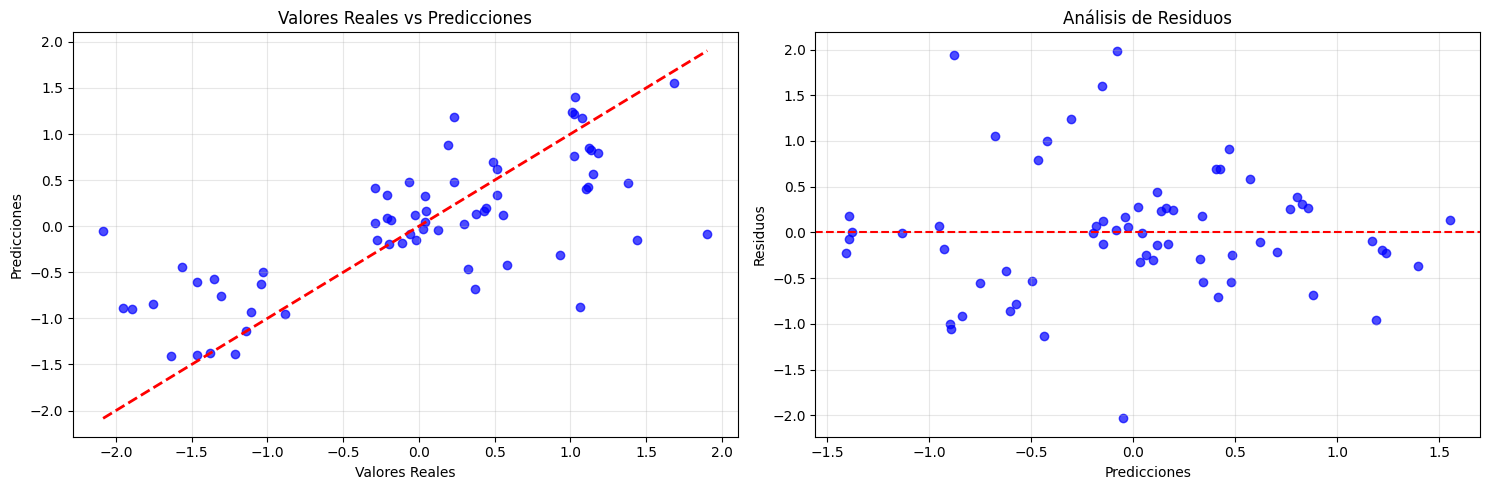

(LinearRegression(),
 {'r2': 0.5164176096892416,
  'rmse': 0.6954008846059648,
  'mae': 0.4980445306651321,
  'r2_adjusted': 0.49263486918215504})

In [15]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df5)

**Conclusión**

En base a los valores obtenidos en cada modelo generado, se puede apreciar y seleccionar al modelo **M3** como el mejor modelo de todos